## Introduction - notMNIST
The **MNIST** dataset is one of the most popular dataset for learning image classification problems. The **notMNIST** dataset in similar to original MNIST dataset but is considered a bit more **challenging** than its classic version. The dataset is obtained from Kaggle website [here](https://www.kaggle.com/jwjohnson314/notmnist-example/data) and can also be found in its original form on davidflanagan github repo along with its licensing information.


## Problem Context

The notMNIST dataset can be used for multiclass image classification task for classifying letters from A through J. The dataset comes in two versions - notMNIST(**small**) and notMNIST(**large**). The smaller dataset consists of hand-cleaned version with 18726 images and with 0.5% label error rate. The larger dataset is the original uncleaned version with 529119 images and about 6.5% label error rate. 

In this project, we will try to build model a simple model using sklearn SVM classifier and compare its performance with a **deep learning CNN** model built using high level **keras API** for image classification. For our trial models, we will be using the smaller version of notMNIST dataset and then we will deploy the model with better performance on the larger version of the dataset and see how well it performs on the uncleaned version of this dataset. 

#### Importing useful libraries 

In [157]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Model
from keras.layers import Input,Dense,Dropout
from keras.layers import Reshape, Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.models import Sequential


#### Importing all image files
Along with loading images in numpy array, we will also attach labels associated to them and finally resize the stored images in a 1-D array.

In [158]:
X=[]
labels=[]
base_path='notMNIST_small'

for directory in os.listdir(base_path):
    for image in os.listdir(base_path+'/'+directory):
        try:
            file_path=base_path+'/'+directory+'/'+image
            img=Image.open(file_path)
            img.load()
            img_data=np.asarray(img,dtype=np.int16)
            X.append(img_data)
            labels.append(directory)
        except:
            None

Before we proceed towards building our models, we need to randomize our image files by random shuffling to avoid any elements of bias/patterns and make sure that our models remains general.

In [230]:
temp=list(zip(X,labels))
np.random.shuffle(temp)
X,labels=zip(*temp)
X, labels = np.asarray(X), np.asarray(labels)

Lets take a look at some of the images we are working with to gain an insight of the type of images we are working with.

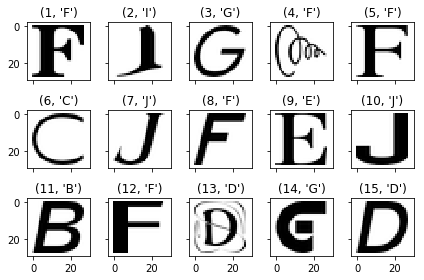

In [231]:
#Plotting some samples images
num_rows, num_cols = 3, 5
fig, ax = plt.subplots(num_rows, num_cols,sharex=True,sharey=True)

ax=ax.flatten()

for i in range(15):
    ax[i].imshow(X[i],cmap='Greys',interpolation='nearest')
    ax[i].set_title((i+1,labels[i]))

plt.tight_layout()
plt.show()

All the images seems fine except the fourth image which is labeled as **F** but is definetely **not F**. Looking at many other samples gives an idea that how label misclassification can limit a model performance. Anyways lets see how our classifiers performs while dealing with such images.

As mentioned previously, the first model we are using is **SVM**. Support vector machine (SVM) is a robust classification tool and has been shown to be one of the most effective machine learning algorithms. It should be noted that to train our SVM on a set of images, we are first required to construct the training matrix for the SVM. Each row in this matrix corresponds to one image which is reshaped from two dimensional to one dimensional numpy array and each element in that row corresponds to one feature of the class that we wish to classify.

In [232]:
N=len(X)
img_size=len(X[0])
X=np.asarray(X).reshape(len(labels),img_size*img_size)

In [233]:
X.shape

(18724, 784)

Next, we need to split our dataset in training and test set. For this, we would use 75% of the images for training and 25% images for model performance evaluation.

In [234]:
X_train,X_test,y_train,y_test=train_test_split(X,labels,
                                               test_size=0.2,
                                               random_state=0)

In [235]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14979, 784)
(3745, 784)
(14979,)
(3745,)


In [236]:
classes=np.unique(y_train)
nclasses=len(classes)
nclasses

10

To fit SVM for our image classification task, lets employ a grid search

In [237]:

param_grid = {'C' : [0.1, 0.5, 1],
              'kernel':['rbf','linear']}

model_svc = GridSearchCV(SVC(random_state=0),
                         param_grid=param_grid,
                         scoring='accuracy',
                         verbose=1,n_jobs=-1)

start=time.time()
model_svc.fit(X_train,y_train)
end=time.time()

print("SVM Training Complete\n")

print('Time Taken to train SVC model : ',(end-start),' sec')

print('Best SVM Parameter Set: %s'%model_svc.best_params_)

svc_predictions=model_svc.predict(X_test)

print('Model_1 SVM Accuracy Score : %.3f ' %(accuracy_score(y_test,svc_predictions,normalize=True)))
print('Model_1 F1 Score : %.3f ' %(f1_score(y_test,svc_predictions,average='micro')))
print('Model_1 Classification Report\n' ,classification_report(y_test,svc_predictions))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 30.7min finished


SVM Training Complete

Time Taken to train SVC model :  1910.1942329406738  sec
Best SVM Parameter Set: {'C': 0.1, 'kernel': 'linear'}
Model_1 SVM Accuracy Score : 0.854 
Model_1 F1 Score : 0.854 
Model_1 Classification Report
              precision    recall  f1-score   support

          A       0.81      0.89      0.85       369
          B       0.84      0.86      0.85       379
          C       0.82      0.90      0.86       366
          D       0.88      0.89      0.89       360
          E       0.78      0.82      0.80       366
          F       0.91      0.85      0.88       357
          G       0.89      0.78      0.83       390
          H       0.88      0.84      0.86       406
          I       0.86      0.83      0.84       369
          J       0.90      0.88      0.89       383

avg / total       0.86      0.85      0.85      3745



The SVM classifier gave us an accuracy and f1-score of about 85.5% with linear kernel and 'C' value as 0.1.

Next we will use a deep CNN network which are widely used for image classification and computer vision problems these days and have proven to be very effective in such problems.

## Deep Learning and Computer Vision

To implement a model for computer vision problem, we will build a convolutional neural network using **convolutional** and **pooling layers** which will serve the purpose of feature extraction from our images. These layers will be followed by **fully connected layers** which will perform non-linear transformations on the features extracted. We will also include **Dropout** as a form of regularization to prevent our model from overfitting.

Note that categorical labels in our dataset needs to be converted to numerical form in order to feed our data to the neural network. For this purpose, we ill use **MultiLabelBinarizer** method from sklearn library.

In [244]:
le=MultiLabelBinarizer()
labels_enc=le.fit_transform(labels)
labels_enc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Also, we can feed our CNN model with 2-D images directly. Hence lets convert our flattened images back into their original form and split our dataset in 90% training and 10% test sets.

In [245]:
X=np.asarray(X).reshape(N,28,28,1)
X_train,X_test,y_train,y_test=train_test_split(X,labels_enc, 
                                               test_size=0.1,
                                               random_state=0)

In [246]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16851, 28, 28, 1)
(16851, 10)
(1873, 28, 28, 1)
(1873, 10)


### CNN Model description
We will be using 6 convolutional layers followed by 1 fully connected layer. The first two layers will have 16 and 32 filters respectively of filter size as 3X3 and 'Relu' activation (no padding) followed by a max-pooling layer with pool size as 2X2. The following two layers will have 32 and 64 filters respectively of filter size as 3X3 and 'Relu' activation (no padding) followed by a max-pooling layer with pool size as 2X2. The last convolutional layers will have two layers with 64 and 128 filters respectively of filter size as 3X3 and 'Relu' activation (no padding) followed by a max-pooling layer with pool size as 2X2. All the blocks (A block here is two convolutional layers followed by a pooling layer) will add a dropout layer with dropout ratio of 0.3.
The final layers consists of a fully connected layer with 'Relu' activation, dropout layer with dropout ratio of 0.5 and a fully connected layer which performs classification using a softmax function among our 10 classes.

In [259]:
shape=X[0].shape
nClasses=10
def createModel():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
 
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

To check the summary of our model, we can first compile the model and call summary method to see the shapes of each layer. Also, the summary method lists out the total number of parameters that we need to fit to train our model.

In [266]:
model=createModel()
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_137 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 5, 5, 64)          0         
__________

By looking at model summary, we can deduce that second conv layer shrinks by 2 pixels in both dimensions. Also, the output size after pooling layer decreases by half since we have used a stride of 2 and a window size of 2X2. The final droupout layer has an output of 1X1X128. This has to be converted to a single array which is accomplished by the flatten layer. The final layer has 10 nodes since there are 10 classes.

In [267]:
start=time.time()
cnn=model.fit(X_train,y_train,epochs=10,
         batch_size=64,validation_data=[X_test,y_test],
         verbose=1)
end=time.time()
print('CNN Training Complete\n')
print('Time Taken to train CNN %.2f'%(end-start),' sec')

Train on 16851 samples, validate on 1873 samples
Epoch 1/10
16851/16851 [==============================] - 47s 3ms/step - loss: 1.1207 - acc: 0.6404 - val_loss: 0.3983 - val_acc: 0.8820
Epoch 2/10
16851/16851 [==============================] - 47s 3ms/step - loss: 0.4322 - acc: 0.8723 - val_loss: 0.3065 - val_acc: 0.9050
Epoch 3/10
16851/16851 [==============================] - 46s 3ms/step - loss: 0.3519 - acc: 0.8970 - val_loss: 0.3004 - val_acc: 0.9114
Epoch 4/10
16851/16851 [==============================] - 46s 3ms/step - loss: 0.3071 - acc: 0.9096 - val_loss: 0.2777 - val_acc: 0.9156
Epoch 5/10
16851/16851 [==============================] - 45s 3ms/step - loss: 0.2913 - acc: 0.9147 - val_loss: 0.3426 - val_acc: 0.8927
Epoch 6/10
16851/16851 [==============================] - 44s 3ms/step - loss: 0.2675 - acc: 0.9234 - val_loss: 0.2334 - val_acc: 0.9279
Epoch 7/10
16851/16851 [==============================] - 43s 3ms/step - loss: 0.2616 - acc: 0.9249 - val_loss: 0.2135 - val_acc:

In [269]:
score = model.evaluate(X_test, y_test, verbose=False)
print('Loss: {}'.format(score[0]))
print('Accuracy: {}%'.format(np.round(100*score[1])))

Loss: 0.2753205830226337
Accuracy: 93.0%


We achieved an accuracy score of 93% which means that our CNN model has generalized very well. Also, this score is very impressise as compared to our SVM model we built earlier in this project. This confirms the fact that CNN model can perform really better for image classification and computer vision problems as compared to traditional classifiers such as SVM. 

We can plot the model accuracy history to see how the accuracy of train and validation data model improved over the epochs in our model. 

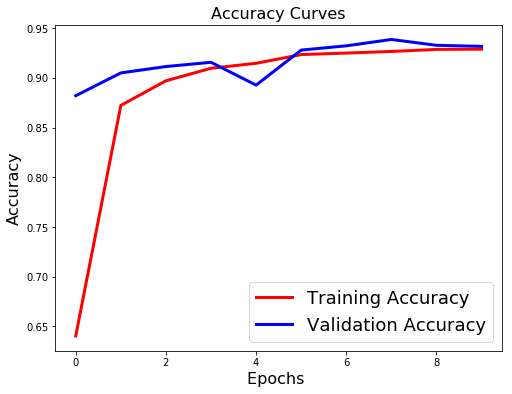

In [273]:
plt.figure(figsize=[8,6])
plt.plot(cnn.history['acc'],'r',linewidth=3.0)
plt.plot(cnn.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()